In [1]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [425]:
# reload helper and methods for when things change
reload(m);
reload(h);

True W:
[[ 0.44  0.    0.    0.    0.  ]
 [ 0.    0.57  0.    0.    0.  ]
 [-0.65  0.    0.59  0.    0.  ]
 [ 0.68 -0.62  0.    0.41  0.  ]
 [ 0.45  0.41 -0.5   0.    0.  ]].



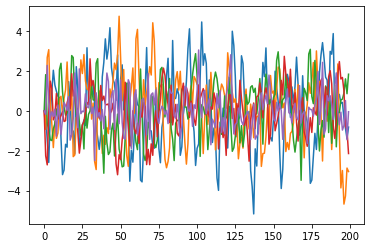

In [455]:
np.random.seed(seed = 1234)

## Number of dimensions, number of edges, number of samples
T, n, s = 200, 5, 10

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
A_true = h.generate_A(n, s, tril = False, low = 0.30, high = 0.70)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_true)):
    A_true[i][i] = np.abs(A_true[i][i])

## True permutation
P_true = np.identity(n) # np.random.permutation(np.identity(n))

## Datagenerating W
W_true = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(W_true, 2)}.\n")

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

In [427]:
def normalize(x):
    return x / (np.linalg.norm(x, 2))

W_NORM:
 [[ 0.44312691  0.          0.          0.          0.        ]
 [ 0.          0.57338517  0.          0.          0.        ]
 [-0.65037305  0.          0.58508081  0.          0.        ]
 [ 0.68325574 -0.62074887  0.          0.4105857   0.        ]
 [ 0.4481003   0.40903704 -0.50039805  0.          0.        ]] 

[22.11 20.23 19.2  18.15 17.1  16.55 16.07 15.85 15.66 15.53 15.46 15.42
 15.35 15.34 15.34]

W_OMP_PAPER:
 [[ 0.304  0.     0.     0.     0.   ]
 [-0.154  0.525  0.     0.     0.   ]
 [-1.17  -0.065  0.598  0.     0.   ]
 [ 0.655 -0.694  0.023  0.445  0.   ]
 [ 0.4    0.377 -0.322 -0.224  0.177]]

W_OMP:
 [[ 0.291  0.     0.     0.     0.   ]
 [-0.14   0.547  0.     0.     0.   ]
 [-1.188 -0.066  0.585  0.     0.   ]
 [ 0.619 -0.731 -0.023  0.4    0.   ]
 [ 0.413  0.391 -0.309 -0.211  0.191]]
[0, 6, 8, 3, 2, 18, 12, 4, 9, 14, 19, 24, 1, 7, 13]


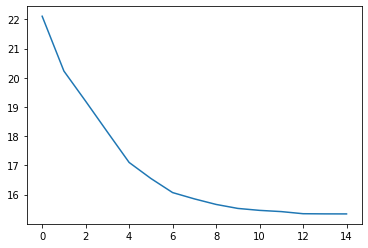

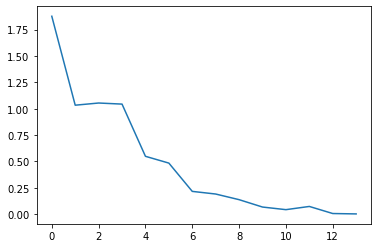

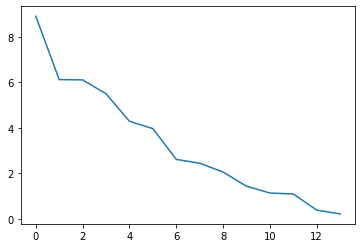

In [456]:
def OMP_MATRIX_DAG(X, Y, max_coefs = int(1e10), tol = 0.0):
    
    # intialize F
    F = set()
    
    # extra information
    Ws, mses, max_gains = [], [], []
    
    # forbidden indices
    N = set()
    
    # initialize beta
    W = np.zeros((n, n))
    
    for coef in range(min(n ** 2, max_coefs)):
        # get the gains
        gains = np.array([np.abs(normalize(X[:, i]) @ ((X @ W)[:, j] - Y[:, j])) for j in range(n) for i in range(n)])
        
        # set the forbidden coefficients to negative value, so that they will never be chosen
        gains[list(N)] = -np.ones(len(list(N)))
        
        # find the index that maximizes the gains
        i_max = np.argmax(gains)

        # check if the gain is large enough
        if max(gains) <= tol: break
        
        # add index to F
        F.add(i_max)
        
        # update residuals
        W_new = update_W(list(F), X, Y)
        
        # check if adding this beta will yield a cycle
        if h.is_dag(W_new):
            # if not, we add it
            W = W_new
            
            # append to iterative list of W
            Ws.append(W)
            
            # append max gains
            max_gains.append(max(gains))
            
            # check the current mean squared error    
            mses.append(np.linalg.norm(Y - X @ Ws[-1], 'f'))
            
        else:
            # if so, we remove it, and add it to the forbidden list
            F.remove(i_max)
            N.add(i_max)
        
        # print for feedback
        # print(f"MaxGain: {np.round(max(gains), 2)}.")
        # print(f"Gain: {np.round(gains, 2)}.")
        # print(f"Betas:\n{np.round(betas, 2)}.\n")
    
    # return betas
    return W.reshape(n, n), Ws, mses, max_gains

print("W_NORM:\n", W_true, "\n")
T = 50
X = h.generate_var_2(T, n, W_true, np.identity(n))
W_OMP_paper, edge_order, Ws, mses, max_gains = OMP_MATRIX_DAG(X[:-1], X[1:], tol = 0.0)

print(np.round(mses, 2))

W_OMP, edges, scores = m._OMP(X, get_order = True)
print("\nW_OMP_PAPER:\n", np.round(W_OMP_paper, 3))
print("\nW_OMP:\n", np.round(W_OMP, 3))

print(edge_order)

mses = np.array(mses)
plt.plot(mses)
plt.show()
plt.plot(mses[:-1] - mses[1:])
plt.show()
plt.plot(max_gains[1:])

In [279]:
print(len(W_true.flatten()), len(W_true.nonzero()[0]))

25 0


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


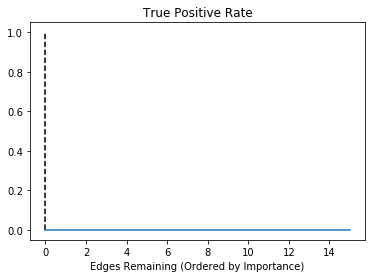

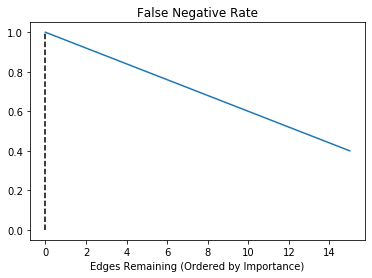

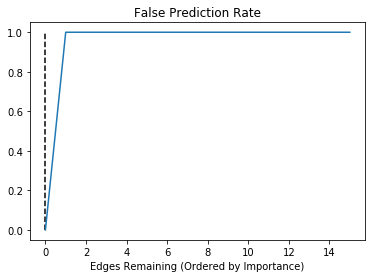

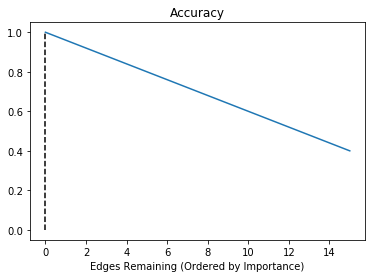

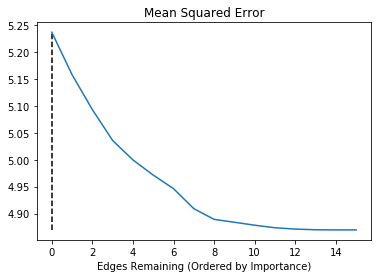

array([5.23719754, 5.15817563, 5.09324596, 5.03579986, 4.9997012 ,
       4.97149642, 4.94624739, 4.90907735, 4.88914404, 4.8837631 ,
       4.87828691, 4.87354007, 4.87109755, 4.86980664, 4.86953845,
       4.86952555])

In [280]:
# Let us see what happens when we remove edges
def order_edges2(X, Ws, plotting = True):
    
    results = [h.score(X, np.zeros((n, n)), W_true, printing = False)]
    
    for W in Ws:              
        ## check scores
        # tpr: True Positive Rate; Rate of correctly predicted edges.
        # fnr: True Negative Rate; Rate of corretly predicted non-edges.
        # fpr: False Prediction Rate; Rate of predicted edges that are not edges.
        # acc: Accuracy; Rater of correctly predicted edges and non-edges.
        # mse: Mean Squared Error: Average squared L2 loss per timestep
        results.append(h.score(X, W, W_true, printing = False))
    
    results = np.array(results)
    
    titles = ['True Positive Rate', 'False Negative Rate', 'False Prediction Rate', 'Accuracy', 'Mean Squared Error']
    
    if plotting:
        for i in range(4):
            plt.title(titles[i])
            plt.xlabel("Edges Remaining (Ordered by Importance)")
            plt.plot(range(0, len(Ws) + 1), results[:, i])
            plt.vlines(s, 0, 1, linestyle = '--')
            plt.show()
    
#        plt.ylabel("Mean Squared Error (MSE)")
        plt.xlabel("Edges Remaining (Ordered by Importance)")
        plt.title(titles[-1])
        plt.plot(range(0, len(Ws) + 1), results[:, 4])
        plt.vlines(s, min(results[:, 4]), max(results[:, 4]), linestyle = '--')
        #plt.vlines(np.argmin(results[:, 4]), 0, max(results[:, 4]), linestyle = '--', color = 'green')
        plt.show()
    
    return results[:, 4]

order_edges2(X, Ws)

[[-0.07 -0.19 -0.07  0.    0.3 ]
 [ 0.    0.01  0.    0.    0.  ]
 [ 0.    0.16  0.24  0.22  0.  ]
 [ 0.    0.18  0.    0.03  0.  ]
 [ 0.   -0.08  0.21  0.15 -0.05]] 


True Positive Rate: 0.0.
True Negative Rate: 0.4.
False Prediction Rate: 1.0
Accuracy: 0.4.
R-Squared: 0.069
Mean Squared Error: 4.87
True Positive Rate: 0.0.
True Negative Rate: 0.44.
False Prediction Rate: 1.0
Accuracy: 0.44.
R-Squared: 0.069
Mean Squared Error: 4.87
[[-0.07 -0.19 -0.07  0.    0.3 ]
 [ 0.    0.01  0.    0.    0.  ]
 [ 0.    0.16  0.24  0.22  0.  ]
 [ 0.    0.18  0.    0.03  0.  ]
 [ 0.   -0.08  0.21  0.15 -0.05]] 


True Positive Rate: 0.0.
True Negative Rate: 0.48.
False Prediction Rate: 1.0
Accuracy: 0.48.
R-Squared: 0.069
Mean Squared Error: 4.87
[[-0.07 -0.19 -0.07  0.    0.3 ]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.    0.16  0.24  0.22  0.  ]
 [ 0.    0.18  0.    0.03  0.  ]
 [ 0.   -0.08  0.21  0.15 -0.05]] 


True Positive Rate: 0.0.
True Negative Rate: 0.52.
False Prediction Rate: 1.0
Accuracy:

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


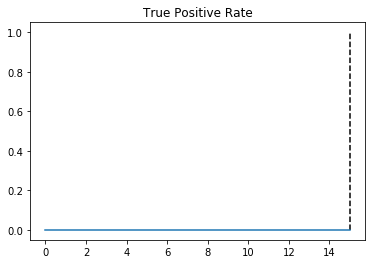

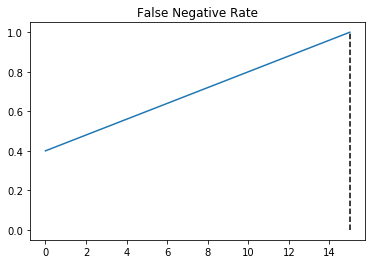

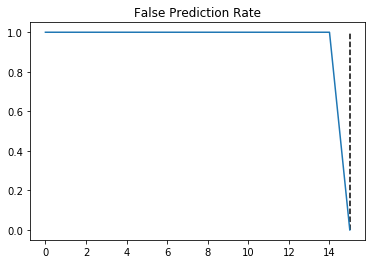

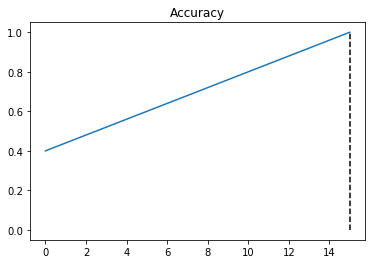

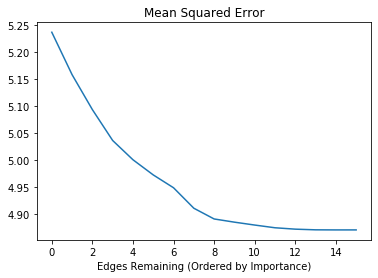

([array([[-0.07006197, -0.19303824, -0.06784053,  0.00244082,  0.29563781],
         [ 0.        ,  0.01056255,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.16301701,  0.24398059,  0.21922924,  0.        ],
         [ 0.        ,  0.17745994,  0.        ,  0.02604357,  0.        ],
         [ 0.        , -0.07659357,  0.20631424,  0.14539076, -0.04751863]]),
  array([[-0.07006197, -0.19303824, -0.06784053,  0.        ,  0.29563781],
         [ 0.        ,  0.01056255,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.16301701,  0.24398059,  0.21922924,  0.        ],
         [ 0.        ,  0.17745994,  0.        ,  0.02604357,  0.        ],
         [ 0.        , -0.07659357,  0.20631424,  0.14539076, -0.04751863]]),
  array([[-0.07006197, -0.19303824, -0.06784053,  0.        ,  0.29563781],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.16301701,  0.24398059,  0.21922924,  0.        ],
        

In [281]:
# Let us see what happens when we remove edges
def order_edges(X, W, edges, plotting = True):
    
    W_list = [W]
    results = []
    
    # copy edges in a matrix that we iteratively shrink
    W_remove = W.copy()
    
    # print W
    if plotting:
        print(np.round(W_remove, 2), "\n")
        print()
        
    # check scores
    result = h.score(X, W_remove, W_true, printing = plotting)
    results.append(result)
    
    
    for i in range(len(edges)):
        # remove this edge from W
        W_remove[edges[-(i + 1)][0] - 1][edges[-(i + 1)][1] - 1] = 0
    
        ## check scores
        # tpr: True Positive Rate; Rate of correctly predicted edges.
        # fnr: True Negative Rate; Rate of corretly predicted non-edges.
        # fpr: False Prediction Rate; Rate of predicted edges that are not edges.
        # acc: Accuracy; Rater of correctly predicted edges and non-edges.
        # mse: Mean Squared Error: Average squared L2 loss per timestep
        result = h.score(X, W_remove, W_true, printing = plotting)
        
        results.append(result)
        W_list.append(W_remove.copy())
        
        # print W
        if plotting: 
            print(np.round(W_remove, 2), "\n")
            print()
    
    results = np.array(results)
    
    titles = ['True Positive Rate', 'False Negative Rate', 'False Prediction Rate', 'Accuracy', 'Mean Squared Error']
    
    if plotting:
        for i in range(4):
            plt.title(titles[i])
            plt.plot(range(0, len(edges) + 1), results[:, i])
            plt.vlines(n * (n + 1) / 2 - s, 0, 1, linestyle = '--')
            plt.show()
    
        #plt.ylabel("Mean Squared Error (MSE)")
        plt.xlabel("Edges Remaining (Ordered by Importance)")
        plt.title(titles[-1])
        plt.plot(range(0, len(edges) + 1), np.flip(results[:, 4]))
        #plt.vlines(np.argmin(np.log(results[:, 4])), 0, max(np.log(results[:, 4])), linestyle = '--', color = 'green')
        plt.show()
    
    return W_list, results[:, 4]

order_edges(X, W_OMP, edges)

In [125]:
print([W for W in Ws])

[array([[ 0.        ,  0.        ,  0.        ],
       [-0.66627859,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.        ],
       [-0.66627859,  0.63564771,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.        ],
       [-0.66627859,  0.53913982,  0.        ],
       [ 0.        ,  0.72116012,  0.        ]]), array([[ 0.        ,  0.        ,  0.        ],
       [-0.66627859,  0.53913982,  0.        ],
       [ 0.        ,  0.72116012,  0.35685873]]), array([[-0.0437471 ,  0.        ,  0.        ],
       [-0.68538812,  0.53913982,  0.        ],
       [ 0.        ,  0.72116012,  0.35685873]]), array([[-0.04416407,  0.        ,  0.        ],
       [-0.68642269,  0.53913982,  0.        ],
       [ 0.0063698 ,  0.72116012,  0.35685873]])]


In [78]:
from statsmodels.api import OLS

def update_betas(F, X, Y):
    """Compute OLS coefficients using only the entries in F"""
    
    # fit only using coefficients in F
    X_F = np.kron(np.eye(n, dtype=float), X)[:, F]
    
    # fit
    ols_fit = OLS(Y.T.flatten(), X_F).fit()
    
    # get parameters
    params = np.zeros(n ** 2)
    params[F] = ols_fit.params
    
    return params.reshape(n, n).T

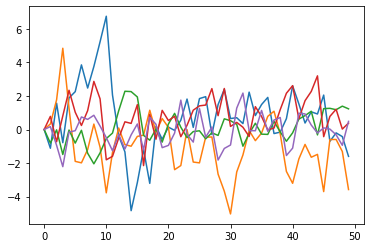

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 

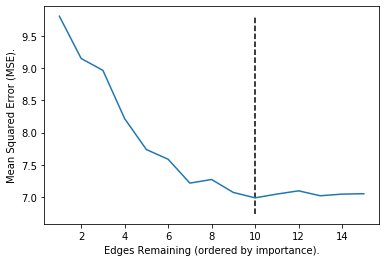

In [471]:
def LOOCV(X):
   
    mses_avg = []
    
    for i in range(0, T - 1):
        print(i, end = ", ")
        # run OMP on all excluding one X_i
        # we do this by simply attaching X_i+1: to X_:i-1
        # however, the gap is too large, so we need to remove the "effect" of X_i
        # we do this by subtracting the difference between X_i and X_i-1 from X_i+1:
        X_train = np.delete(X, i, axis = 0)

        # run OMP
        W, order, Ws, mses, max_gains = OMP_MATRIX_DAG(X_train[:-1], X_train[1:])
        
        mses = []
        for W in Ws:
            mses.append(np.linalg.norm(X[i + 1, :] - X[i, :] @ W, 2))
        
        mses_avg.append(mses)
        # test OMP on only one Y_i
        # for this, we need to give X_i as well X_i+1.
        
        # calculate the mean squared error in order of edges
        # we need to refit OMP everytime for this
        
    mses_avg = np.array(mses_avg) 
    
    avg = np.sum(mses_avg, axis = 0) / len(mses_avg[1])
              
    plt.xlabel("Edges Remaining (ordered by importance).")
    plt.ylabel("Mean Squared Error (MSE).")
    plt.vlines(np.argmin(avg) + 1, min(avg) - 0.25, max(avg), linestyle = '--')
    plt.plot(range(1, len(avg) + 1), avg)
    
    return avg


plt.plot(X)
plt.show()
mses_avg = LOOCV(X)

In [463]:
print(mses_avg)
i = np.argmin(mses_avg)
print(i)
print(np.round(Ws[1], 2))

[9.8098237  9.15292369 8.96819202 8.21734632 7.73644615 7.58566662
 7.21452248 7.27056746 7.06915283 6.98525708 7.0435435  7.09427936
 7.01762712 7.04318047 7.04937015]
9
[[0.68 0.   0.   0.   0.  ]
 [0.   0.67 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]


In [459]:
print(W_true)

[[ 0.44312691  0.          0.          0.          0.        ]
 [ 0.          0.57338517  0.          0.          0.        ]
 [-0.65037305  0.          0.58508081  0.          0.        ]
 [ 0.68325574 -0.62074887  0.          0.4105857   0.        ]
 [ 0.4481003   0.40903704 -0.50039805  0.          0.        ]]


In [407]:
def OMP_MATRIX_DAG_2(X, Y, max_coefs = int(1e10), tol = 0.0, verbose = False, output = False):
    
    # intialize F
    F = np.full((n, n), False)
    
    # forbidden indices
    N = set()
    
    # output
    Ws, mses, max_gains = [], [], []
    
    # initialize beta
    betas = np.zeros((n, n))
    
    # greedy for loop
    for coef in range(min(n ** 2, max_coefs)):
        
        # get the gains
        gains = np.array([np.abs(normalize(X[:, i]) @ ((X @ betas)[:, j] - Y[:, j])) for j in range(n) for i in range(n)])
        
        # set the forbidden coefficients to negative value, so that they will never be chosen
        gains[list(N)] = -np.ones(len(list(N)))
        
        # find the index that maximizes the gains
        i_max = np.argmax(gains)

        # check if the gain is large enough
        if max(gains) <= tol: break
        
        # add index to F
        F[i_max % n][i_max // n] = True
        
        # get 2D indices based on flattened index i_max
        row, col = i_max % n, i_max // n
        
        # check if we still have a DAG
        if h.is_dag(F):   
            # if so, calculate new betas using only atoms in F
            X_F = X[:, F[:, col]]
            betas[F[:, col], col] = np.linalg.inv(X_F.T @ X_F) @ X_F.T @ Y[:, col]
            
            # append to iterative list of W
            Ws.append(betas.reshape(n, n))
            
            # append max_gains
            max_gains.append(max(gains))
            
            # check the current mean squared error    
            mses.append(np.linalg.norm(Y - X @ Ws[-1], 'f'))
        else:
            # if we do not have a DAG, we remove it, and add it to the forbidden list
            F[row][col] = False
            N.add(i_max)
        
        # print for feedback
        if verbose:
            print(f"MaxGain: {np.round(max(gains), 2)}.")
            print(f"Gain: {np.round(gains, 2)}.")
            print(f"Betas:\n{np.round(betas, 2)}.\n")
            print(f"F: {F}.")
        
    # return betas and extra infor if we care about it
    if output:
        return betas.reshape(n, n), Ws, mses, max_gains
    
    # if we do not care about output, we only return betas
    return betas

W_NORM:
 [[0.50662098 0.         0.5       ]
 [0.         0.         0.        ]
 [0.         0.         0.472124  ]] 

[134.24 127.57 121.4  121.37 121.36 121.36]

W_OMP_PAPER:
 [[ 0.499  0.019  0.493]
 [ 0.     0.     0.   ]
 [ 0.    -0.007  0.475]]

W_OMP:
 [[ 0.499  0.019  0.493]
 [ 0.     0.     0.   ]
 [ 0.    -0.008  0.475]]
[8, 0, 6, 1, 4, 7, 8, 8, 0, 6, 7, 4, 3, 8, 0, 6, 3, 5, 4, 8, 0, 6, 1, 4, 7]


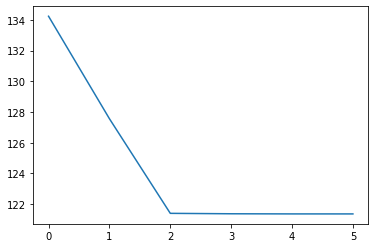

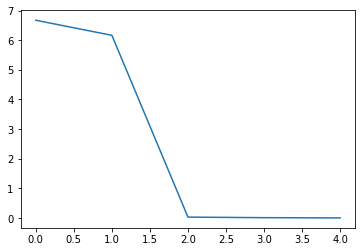

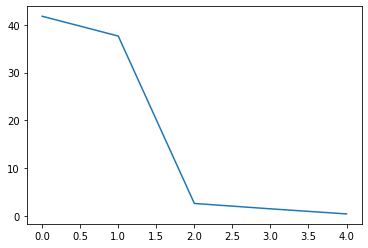

In [408]:
print("W_NORM:\n", W_true, "\n")
T = 5000
X = h.generate_var_2(T, n, W_true, np.identity(n))

In [422]:
W_OMP_DAG = OMP_MATRIX_DAG_2(X[:-1], X[1:], tol = 0.0)
print("\nW_OMP_DAG:\n", np.round(W_OMP_DAG, 3))


W_OMP_DAG:
 [[-0.026  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.621  0.41  -0.027  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.023  0.     0.471  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.394 -0.009 -0.515  0.439  0.    -0.051  0.     0.     0.     0.   ]
 [ 0.079  0.567  0.022 -0.316  0.624 -0.005  0.     0.     0.     0.   ]
 [-0.046  0.696  0.007  0.     0.    -0.01   0.     0.     0.     0.   ]
 [-0.021 -0.371  0.52  -0.029 -0.281  0.001  0.045  0.     0.     0.   ]
 [-0.016  0.003  0.001 -0.025  0.315 -0.02   0.406  0.606  0.     0.   ]
 [-0.008 -0.021  0.467  0.567 -0.386 -0.389  0.031 -0.508 -0.001 -0.061]
 [ 0.025  0.023  0.043 -0.008  0.025  0.601 -0.397  0.574  0.     0.677]]


In [421]:
W_OMP, edges, scores = m._OMP(X, get_order = True)
print("\nW_OMP:\n", np.round(W_OMP, 3))


W_OMP:
 [[-0.026  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.621  0.41  -0.027  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.023  0.     0.47   0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.393 -0.01  -0.516  0.439  0.    -0.052  0.     0.     0.     0.   ]
 [ 0.078  0.567  0.021 -0.317  0.624 -0.006  0.     0.     0.     0.   ]
 [-0.047  0.694  0.006  0.     0.    -0.011  0.     0.     0.     0.   ]
 [-0.021 -0.371  0.52  -0.029 -0.281  0.002  0.046  0.     0.     0.   ]
 [-0.015  0.004  0.002 -0.025  0.316 -0.019  0.406  0.607  0.     0.   ]
 [-0.008 -0.021  0.467  0.567 -0.386 -0.389  0.031 -0.508 -0.001 -0.06 ]
 [ 0.025  0.023  0.043 -0.008  0.025  0.601 -0.397  0.574  0.     0.677]]


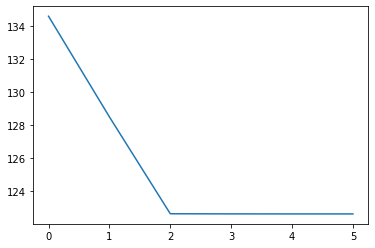

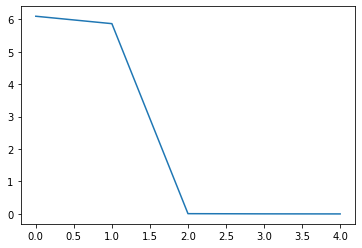

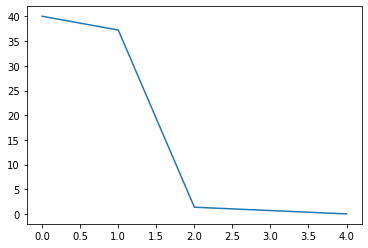

In [413]:
W_OMP_DAG, Ws, mses, max_gains = OMP_MATRIX_DAG_2(X[:-1], X[1:], tol = 0.0, output = True)
mses = np.array(mses)
plt.plot(mses)
plt.show()
plt.plot(mses[:-1] - mses[1:])
plt.show()
plt.plot(max_gains[1:])